In [49]:
import json

from extraction_pipeline.job_post_extraction_pipeline import JobPostSkillExtractor
import numpy as np
import pandas as pd
from scipy import linalg
import re 
from sklearn.cluster import KMeans
from sklearn import cluster
import sklearn
import matplotlib.pyplot as plt


### Read dobie output

In [50]:
with open('skills.json') as json_file:
    skills = json.load(json_file)
    # for p in skills:
    #     print(p)


extractor = JobPostSkillExtractor()
job_posts = extractor.get_job_posts()

### Create job posts - skills Matrix

In [51]:
A = np.zeros((len(job_posts), len(skills)))


In [52]:
def camel_case_split(str): 
    return re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str) 

In [53]:
idx = 0
for s in skills:
    skl = s['string']
    idx_arr = pd.Index(job_posts.requirements).str.contains(skl, regex=False)

    if np.all(idx_arr == False):
        skls = camel_case_split(skl)

        idx_arr = pd.Index(job_posts.requirements).str.contains(skl[0], regex=False) & (pd.Index(job_posts.requirements).str.contains(skl[1], regex=False))
        print(idx_arr)
        print(np.all(idx_arr == False))
    
    A[idx_arr, idx] = 1
    idx += 1

col_sums = np.sum(A,axis=0)
print(col_sums.shape)


[False  True  True ... False False False]
False
[ True  True  True ...  True False  True]
False
[ True  True  True ...  True False  True]
False
[False False False ...  True  True  True]
False
[ True  True  True ...  True False  True]
False
[ True  True  True ... False False  True]
False
[ True  True False ... False  True  True]
False
[ True  True  True ...  True False  True]
False
[False  True False ...  True False False]
False
[ True  True  True ...  True False  True]
False
[ True  True  True ...  True False  True]
False
[ True  True False ... False  True  True]
False
[ True  True  True ...  True False  True]
False
[ True  True  True ...  True False  True]
False
(95,)


In [54]:
print(A)
print(A.shape)

[[0. 0. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 1. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]]
(1777, 95)


###  Filter out job posts with none of the identified skills and skills that are common to more than 500 job posts

In [55]:
zero_rows = np.where(np.sum(A, axis=1)==0)[0]

In [56]:
A_reduced = A[np.sum(A, axis=1)>0]
A_reduced.shape

reduced_skill_indices = np.where(np.sum(A_reduced, axis=0)<500)[0]

A_reduced2 = A_reduced[:,(np.sum(A_reduced, axis=0)<500)]
print(A_reduced2.shape)
print(reduced_skill_indices)

(1568, 79)
[ 0  3  4  5  6  7  8  9 14 15 17 19 20 21 22 24 25 26 27 28 29 30 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 53 54 55 56 57 58
 59 60 61 62 63 64 65 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 84
 85 86 88 89 91 92 93]


In [57]:
def find_max_silhouette_K(X, min_k=2, max_k=16):
    silhouette_score_values=list()

    NumberOfClusters=range(min_k, max_k)

    for i in NumberOfClusters:

        classifier=cluster.KMeans(i,init='k-means++', random_state=0)
        classifier.fit(X)
        labels= classifier.predict(X)
        silhouette_score_values.append(sklearn.metrics.silhouette_score(X,labels ,metric='euclidean', sample_size=None, random_state=None))
 
    Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
    plt.plot(NumberOfClusters, silhouette_score_values)
    plt.title("Silhouette score values vs Numbers of Clusters ")
    plt.show()
    return(Optimal_NumberOf_Components)

In [58]:
def run_K_means(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    labels = kmeans.labels_
    print(np.bincount(labels))

    centroids = kmeans.cluster_centers_

    for c in centroids:
        print(np.sort(-c[c>0.1]))
        for sk in np.argsort(-c)[0:16]:
            print(skills[reduced_skill_indices[sk]]['string'])
    return centroids, labels

### Find optimal number of clusters using silhouette score and run recursive k-means if needed

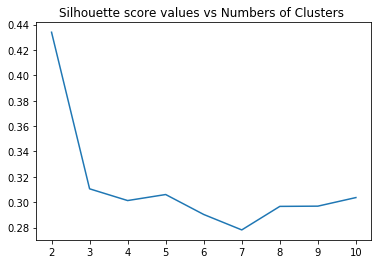

[1520   48]
[-0.25986842 -0.25723684 -0.18355263 -0.17434211 -0.15986842 -0.15
 -0.14473684 -0.14342105 -0.13355263 -0.13026316 -0.10657895 -0.10460526]
SQL
Java
Git
Design
REST
HTML
CSS
Linux
API
UI
JavaScript
Developer
React
Python
HTML5
UX
[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -0.97916667 -0.97916667 -0.97916667 -0.97916667 -0.97916667
 -0.97916667 -0.97916667 -0.97916667 -0.97916667]
Docker
Jenkins
Gradle
Cassandra
Maven
Python
Git
Ruby
Scala
NoSQL
Ansible
Kafka
SQL
Akka
Development
DevOps
0 0.9693877551020408 0.25986842105263175


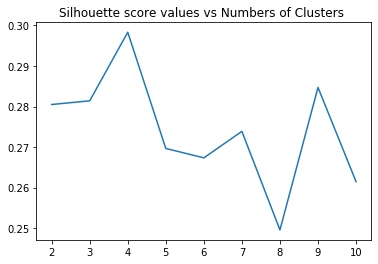

[221 219  91 989]
[-0.95927602 -0.95475113 -0.78280543 -0.6561086  -0.46153846 -0.41176471
 -0.37556561 -0.36199095 -0.31674208 -0.25791855 -0.24434389 -0.24434389
 -0.21719457 -0.17647059 -0.15837104 -0.15837104 -0.15384615 -0.13122172
 -0.13122172 -0.11312217 -0.1040724  -0.1040724 ]
HTML
CSS
Java
HTML5
JavaScript
Git
API
CSS3
SQL
Angular
Design
React
REST
PHP
Linux
AWS
[-0.79908676 -0.67123288 -0.53881279 -0.47945205 -0.39726027 -0.38812785
 -0.34703196 -0.32420091 -0.22374429 -0.18721461 -0.1826484  -0.1826484
 -0.16438356 -0.15981735 -0.15525114 -0.15525114 -0.15068493 -0.13242009
 -0.11415525 -0.11415525 -0.10045662]
REST
Git
Java
SQL
JSON
API
React
Android
Python
Angular
Development
Agile
Linux
NoSQL
JavaScript
Design
[-1. -1. -1. -1. -1. -1.]
Developer
Security
Hardware
UI
UX
Design
SQL
React
Agile
JSON
Angular
JavaScript
PHP
API
Jenkins
Docker
[-0.22244692 -0.14863498 -0.10111223]
SQL
Linux
Java
Python
Design
Windows
Development
Swift
Xcode
Developer
PHP
TCP
Agile
Database
Tes

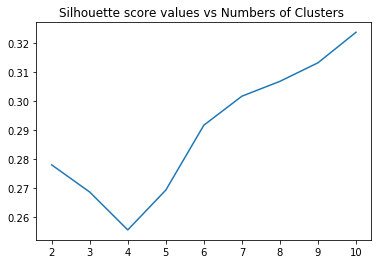

[490  58  52  30  68  12  36 103  82  58]
[]
Windows
Git
UI
CAD
Development
API
Agile
Security
TCP
Testing
REST
UX
Azure
Angular
TypeScript
Cloud
[-1.         -0.79310345 -0.22413793 -0.22413793 -0.15517241 -0.15517241
 -0.15517241 -0.13793103 -0.12068966 -0.12068966 -0.10344828 -0.10344828
 -0.10344828]
Java
SQL
Linux
JavaScript
Angular
Python
Developer
Design
PHP
Development
NoSQL
Agile
Testing
Windows
ERP
Unix
[-1.         -0.98076923]
Swift
Xcode
Python
Java
Linux
Development
Angular
Docker
Perl
CAD
UX
Selenium
Tools
JavaScript
Cassandra
TypeScript
[-1.  -0.8]
Developer
PHP
SQL
Linux
TCP
Azure
Agile
Python
OOP
Programming
Java
Development
Windows
Design
Swift
Xcode
[-1.         -0.5        -0.26470588 -0.22058824 -0.20588235 -0.19117647
 -0.11764706 -0.10294118 -0.10294118]
Python
Linux
Perl
Java
Unix
Bash
SQL
Development
Ruby
Git
Ansible
API
TCP
Docker
Cloud
Agile
[-1.         -1.         -0.66666667 -0.5        -0.5        -0.33333333
 -0.33333333 -0.33333333 -0.16666667 -0.16666

In [59]:
X = A_reduced2
optimal_clusters = find_max_silhouette_K(X, 2,11)
centroids, labels = run_K_means(X, optimal_clusters)

max_cluster = np.argmax(np.bincount(labels))
max_skill_centroid_score = np.max(centroids[max_cluster])

if len(np.where(labels==max_cluster)[0])/len(X) > 0.4 and max_skill_centroid_score < 0.3:
    print(max_cluster, len(np.where(labels==max_cluster)[0])/len(X), max_skill_centroid_score)
    optimal_clusters1 = find_max_silhouette_K(X[labels==max_cluster], 2, 11)
    centroids1, labels1 = run_K_means(X[labels==max_cluster], optimal_clusters1)

    max_cluster1 = np.argmax(np.bincount(labels1))
    max_skill_centroid_score1 = np.max(centroids1[max_cluster1])
    
    if len(np.where(labels1==max_cluster1)[0])/len(labels1) > 0.4 and max_skill_centroid_score1 < 0.3:
        print(max_cluster1, len(np.where(labels1==max_cluster1)[0])/len(labels1), max_skill_centroid_score1)
        optimal_clusters2 = find_max_silhouette_K(X[labels==max_cluster][labels1==max_cluster1], 2, 11)
        centroids2, labels2 = run_K_means(X[labels==max_cluster][labels1==max_cluster1], optimal_clusters2)

        max_cluster2 = np.argmax(np.bincount(labels2))
        max_skill_centroid_score2 = np.max(centroids2[max_cluster2])
        